# Optimization Tutorial

Trey V. Wenger (c) November 2024

Here we demonstrate how to optimize the number of cloud components in a `AbsorptionModel` model.

In [1]:
# General imports    
import numpy as np
import matplotlib.pyplot as plt
import arviz as az
import pandas as pd

import pytensor
print("pytensor version:", pytensor.__version__)

import pymc
print("pymc version:", pymc.__version__)

import bayes_spec
print("bayes_spec version:", bayes_spec.__version__)

import amoeba2
print("amoeba2 version:", amoeba2.__version__)

# Notebook configuration
pd.options.display.max_rows = None

pytensor version: 2.26.3
pymc version: 5.18.2
bayes_spec version: 1.7.2
amoeba2 version: 1.0.1+7.gad490bf.dirty


## Model Definition and Simulated Data

In [2]:
from bayes_spec import SpecData

# spectral axes definition
velo_axis = {
    "1612": np.linspace(-20.0, 20.0, 400), # km s-1
    "1665": np.linspace(-18.0, 18.0, 450),
    "1667": np.linspace(-18.0, 18.0, 450),
    "1720": np.linspace(-15.0, 15.0, 500),
}

# data noise can either be a scalar (assumed constant noise across the spectrum)
# or an array of the same length as the data
rms_absorption = {
    "1612": 0.01,
    "1665": 0.01,
    "1667": 0.01,
    "1720": 0.01,
}

# spectral data. In this case, we just throw in some random data for now
# since we are only doing this in order to simulate some actual data.
absorption = {label: rms_absorption[label] * np.random.randn(len(velo_axis[label])) for label in velo_axis.keys()}

# TauModel expects four observations
dummy_data = {
    f"absorption_{label}": SpecData(
        velo_axis[label],
        absorption[label],
        rms_absorption[label],
        xlabel=r"$V_{\rm LSR}$ (km s$^{-1}$)",
        ylabel=r"$1 - e^{-\tau_{"+f"{label}"+r"}}$"
    )
    for label in velo_axis.keys()
}

# Initialize and define the model
from amoeba2 import AbsorptionModel

# Initialize and define the model
n_clouds = 3
baseline_degree = 0
model = AbsorptionModel(
    dummy_data,
    n_clouds=n_clouds,
    baseline_degree=baseline_degree,
    seed=1234,
    verbose=True
)
model.add_priors(
    prior_tau = [0.1, 0.1], # mean and width of log10(tau) prior
    prior_log10_depth = [0.0, 0.25], # mean and width of log10(depth) prior (pc)
    prior_log10_Tkin = [2.0, 1.0], # mean and width of log10(Tkin) prior (K)
    prior_velocity = [0.0, 5.0], # mean and width of velocity prior (km/s)
    prior_log10_nth_fwhm_1pc = [0.2, 0.1], # mean and width of non-thermal FWHM prior (km/s)
    prior_depth_nth_fwhm_power = [0.4, 0.1], # mean and width of non-thermal FWHM exponent prior
    ordered = False, # do not assume optically-thin
    mainline_pos_tau = True, # force main line optical depths to be positive
)
model.add_likelihood()

# Evaluate likelihood for given model parameters
# excitation temperature for 1612, 1665, and 1667 MHz
inv_Tex_free = np.array([
    [0.2, -0.2, 0.06], # cloud 0
    [0.06, 0.1, 0.2], # cloud 1
    [0.06, 0.06, 0.1] # cloud 2
])

# Evaluate likelihood for given model parameters
sim_params = {
    "tau_1612": np.array([-0.05, 0.05, 0.05]),
    "tau_1665": np.array([0.05, 0.1, 0.02]),
    "tau_1667": np.array([0.02, 0.02, 0.1]),
    "log10_depth": np.array([0.0, 0.25, -0.25]),
    "log10_Tkin": np.array([1.25, 1.75, 1.0]),
    "velocity": np.array([-3.0, 1.0, 3.0]),
    "log10_nth_fwhm_1pc": 0.2,
    "depth_nth_fwhm_power": 0.3,
    "baseline_absorption_1612_norm": [0.0],
    "baseline_absorption_1665_norm": [0.0],
    "baseline_absorption_1667_norm": [0.0],
    "baseline_absorption_1720_norm": [0.0],
}

data = {}
for i, label in enumerate(velo_axis.keys()):
    sim_absorption = model.model[f"absorption_{label}"].eval(sim_params, on_unused_input="ignore")
    data[f"absorption_{label}"] = SpecData(
        velo_axis[label],
        sim_absorption,
        rms_absorption[label],
        xlabel=r"$V_{\rm LSR}$ (km s$^{-1}$)",
        ylabel=r"$1 - e^{-\tau_{"+f"{label}"+r"}}$"
    )

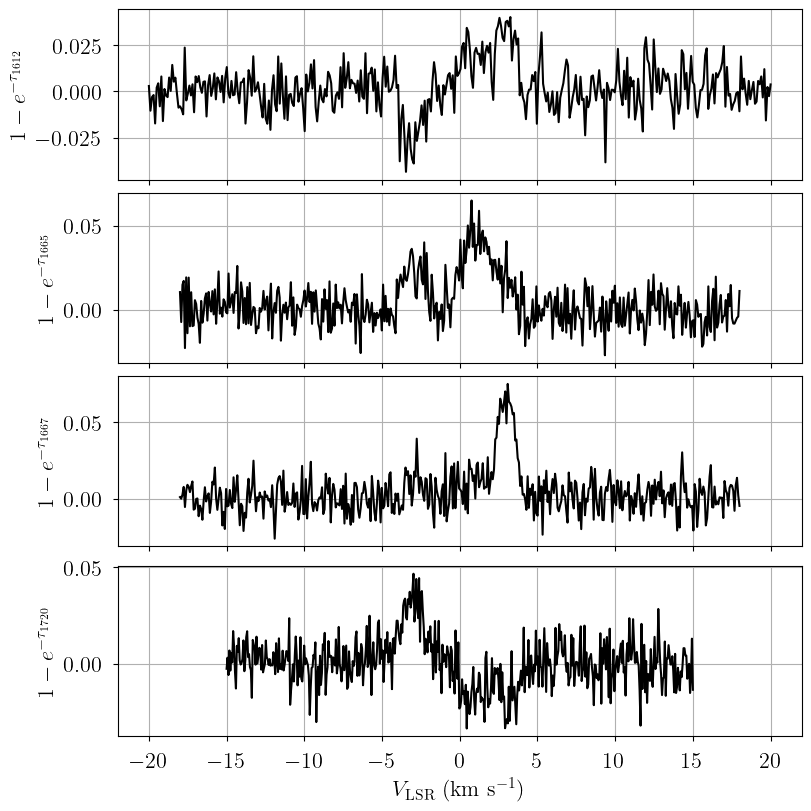

In [3]:
# Plot data
fig, axes = plt.subplots(4, sharex=True, layout="constrained", figsize=(8, 8))
for ax, datum in zip(axes, data.values()):
    ax.plot(datum.spectral, datum.brightness, "k-")
    ax.set_ylabel(datum.ylabel)
_ = axes[-1].set_xlabel(datum.xlabel)

## `Optimize`

We use the `Optimize` class for optimization.

In [4]:
from bayes_spec import Optimize

# Initialize optimizer
opt = Optimize(
    AbsorptionModel,  # model definition
    data,  # data dictionary
    max_n_clouds=5,  # maximum number of clouds
    baseline_degree=2,  # polynomial baseline degree
    seed=1234,  # random seed
    verbose=True,  # verbosity
)

# Define each model
opt.add_priors(
    prior_tau = [0.1, 0.1], # mean and width of log10(tau) prior
    prior_log10_depth = [0.0, 0.25], # mean and width of log10(depth) prior (pc)
    prior_log10_Tkin = [2.0, 1.0], # mean and width of log10(Tkin) prior (K)
    prior_velocity = [0.0, 5.0], # mean and width of velocity prior (km/s)
    prior_log10_nth_fwhm_1pc = [0.2, 0.1], # mean and width of non-thermal FWHM prior (km/s)
    prior_depth_nth_fwhm_power = [0.4, 0.1], # mean and width of non-thermal FWHM exponent prior
    ordered = False, # do not assume optically-thin
    mainline_pos_tau = True, # force main line optical depths to be positive
)
opt.add_likelihood()

`Optimize` has created `max_n_clouds` models, where `opt.models[1]` has `n_clouds=1`, `opt.models[2]` has `n_clouds=2`, etc.

In [5]:
print(opt.models[4])
print(opt.models[4].n_clouds)

4


By default (`approx=True`), the optimization algorithm first loops over every model and approximates the posterior distribution using variational inference. We can supply arguments to `fit` and `sample` via dictionaries. Whichever model is the first to have a BIC within `bic_threshold` of the minimum BIC is the "best" model, and is then sampled with MCMC.

In [6]:
fit_kwargs = {
    "rel_tolerance": 0.01,
    "abs_tolerance": 0.1,
    "learning_rate": 1e-2,
}
sample_kwargs = {
    "chains": 4,
    "cores": 4,
    "init_kwargs": fit_kwargs,
    "nuts_kwargs": {"target_accept": 0.8},
}
opt.optimize(bic_threshold=10.0, sample_kwargs=sample_kwargs, fit_kwargs=fit_kwargs)

Null hypothesis BIC = -9.884e+03
Approximating n_cloud = 1 posterior...


Output()

Convergence achieved at 2300
Interrupted at 2,299 [2%]: Average Loss = -5,023


Output()

n_cloud = 1 BIC = -1.062e+04

Approximating n_cloud = 2 posterior...


Output()

Convergence achieved at 2900
Interrupted at 2,899 [2%]: Average Loss = -5,036


Output()

n_cloud = 2 BIC = -1.093e+04

Approximating n_cloud = 3 posterior...


Output()

Convergence achieved at 3300
Interrupted at 3,299 [3%]: Average Loss = -5,071.2


Output()

n_cloud = 3 BIC = -1.127e+04

Approximating n_cloud = 4 posterior...


Output()

Convergence achieved at 3500
Interrupted at 3,499 [3%]: Average Loss = -4,991.6


Output()

n_cloud = 4 BIC = -1.123e+04

Approximating n_cloud = 5 posterior...


Output()

Convergence achieved at 3600
Interrupted at 3,599 [3%]: Average Loss = -4,851.3


Output()

n_cloud = 5 BIC = -1.117e+04

Sampling best model (n_cloud = 3)...
Initializing NUTS using custom advi+adapt_diag strategy


Output()

Convergence achieved at 3300
Interrupted at 3,299 [3%]: Average Loss = -5,071.2
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [baseline_absorption_1612_norm, baseline_absorption_1665_norm, baseline_absorption_1667_norm, baseline_absorption_1720_norm, tau_1612_norm, tau_1665_norm, tau_1667_norm, log10_depth_norm, log10_Tkin_norm, velocity_norm, log10_nth_fwhm_1pc_norm, depth_nth_fwhm_power_norm]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 62 seconds.


Adding log-likelihood to trace


Output()

GMM converged to unique solution


The "best" model is saved in `opt.best_model`.

In [7]:
print(f"Best model has n_clouds = {opt.best_model.n_clouds}")
az.summary(opt.best_model.trace.solution_0)

Best model has n_clouds = 3


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
baseline_absorption_1612_norm[0],-0.100,0.050,-0.194,-0.005,0.001,0.001,2503.0,2749.0,1.00
baseline_absorption_1612_norm[1],0.163,0.129,-0.090,0.395,0.002,0.002,3557.0,2271.0,1.00
baseline_absorption_1612_norm[2],0.097,0.759,-1.337,1.504,0.015,0.011,2570.0,2724.0,1.00
baseline_absorption_1665_norm[0],-0.345,0.052,-0.445,-0.252,0.001,0.001,1606.0,899.0,1.00
baseline_absorption_1665_norm[1],-0.267,0.114,-0.476,-0.051,0.002,0.001,3771.0,2502.0,1.00
baseline_absorption_1665_norm[2],0.536,0.791,-0.944,1.981,0.027,0.026,964.0,517.0,1.01
baseline_absorption_1667_norm[0],-0.262,0.049,-0.356,-0.175,0.001,0.001,2009.0,2390.0,1.00
baseline_absorption_1667_norm[1],0.133,0.114,-0.088,0.343,0.002,0.002,3321.0,2195.0,1.00
baseline_absorption_1667_norm[2],0.225,0.732,-1.156,1.583,0.016,0.012,1982.0,2480.0,1.00
baseline_absorption_1720_norm[0],0.020,0.051,-0.075,0.115,0.001,0.001,1419.0,2618.0,1.00


Sampling: [absorption_1612, absorption_1665, absorption_1667, absorption_1720]


Output()

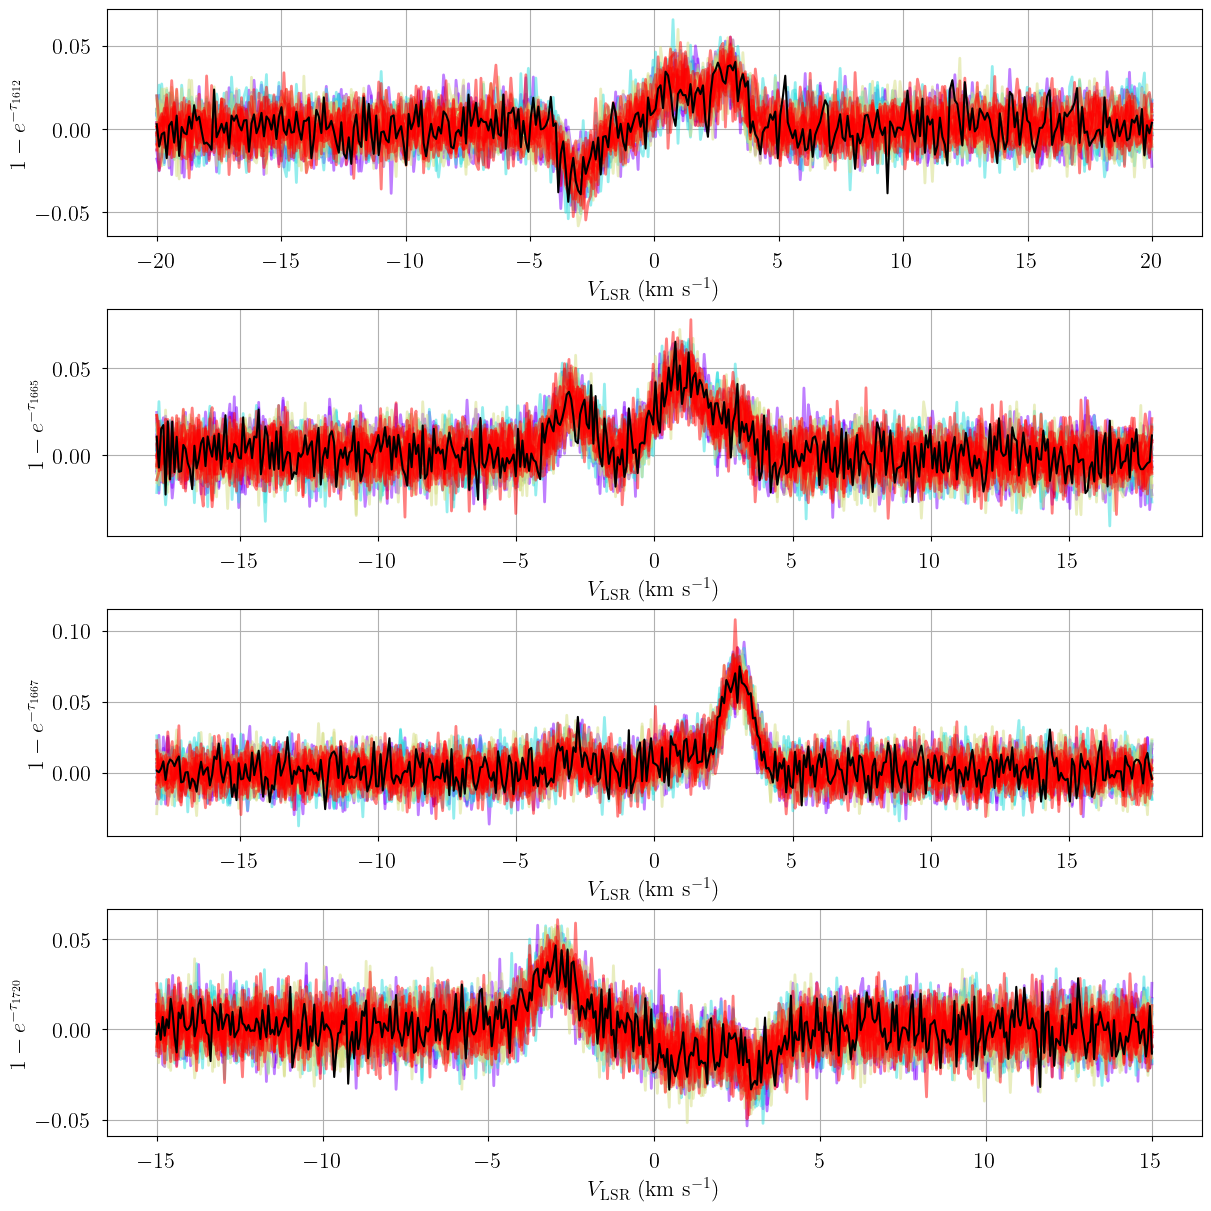

In [8]:
from bayes_spec.plots import plot_predictive

posterior = opt.best_model.sample_posterior_predictive(
    thin=100, # keep one in {thin} posterior samples
)
axes = plot_predictive(opt.best_model.data, posterior.posterior_predictive)
axes.ravel()[0].figure.set_size_inches(12, 12)

## Optimize with MCMC

By default, with `approx=True`, `Optimize` uses VI to fit every model and determine which has the best BIC. VI is only an approximation and can result in poorly converged models. Instead, we can sample every model with MCMC by setting `approx=False`. This will be much slower. It's still important to tune the VI hyperparameters since they are used to initialize MCMC by default.

In [9]:
fit_kwargs = {
    "rel_tolerance": 0.01,
    "abs_tolerance": 0.1,
    "learning_rate": 1e-2,
}
sample_kwargs = {
    "chains": 4,
    "cores": 4,
    "init_kwargs": fit_kwargs,
    "nuts_kwargs": {"target_accept": 0.8},
}
opt.optimize(bic_threshold=10.0, sample_kwargs=sample_kwargs, fit_kwargs=fit_kwargs, approx=False)

Null hypothesis BIC = -9.884e+03
Sampling n_cloud = 1 posterior...
Initializing NUTS using custom advi+adapt_diag strategy


Output()

Convergence achieved at 2300
Interrupted at 2,299 [2%]: Average Loss = -5,023
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [baseline_absorption_1612_norm, baseline_absorption_1665_norm, baseline_absorption_1667_norm, baseline_absorption_1720_norm, tau_1612_norm, tau_1665_norm, tau_1667_norm, log10_depth_norm, log10_Tkin_norm, velocity_norm, log10_nth_fwhm_1pc_norm, depth_nth_fwhm_power_norm]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 80 seconds.


Adding log-likelihood to trace


Output()

There were 15 divergences in converged chains.
GMM converged to unique solution
2 of 4 chains appear converged.
n_cloud = 1 solution = 0 BIC = -1.063e+04

Sampling n_cloud = 2 posterior...
Initializing NUTS using custom advi+adapt_diag strategy


Output()

Convergence achieved at 2900
Interrupted at 2,899 [2%]: Average Loss = -5,036
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [baseline_absorption_1612_norm, baseline_absorption_1665_norm, baseline_absorption_1667_norm, baseline_absorption_1720_norm, tau_1612_norm, tau_1665_norm, tau_1667_norm, log10_depth_norm, log10_Tkin_norm, velocity_norm, log10_nth_fwhm_1pc_norm, depth_nth_fwhm_power_norm]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 53 seconds.


Adding log-likelihood to trace


Output()

GMM converged to unique solution
n_cloud = 2 solution = 0 BIC = -1.095e+04

Sampling n_cloud = 3 posterior...
Initializing NUTS using custom advi+adapt_diag strategy


Output()

Convergence achieved at 3300
Interrupted at 3,299 [3%]: Average Loss = -5,071.2
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [baseline_absorption_1612_norm, baseline_absorption_1665_norm, baseline_absorption_1667_norm, baseline_absorption_1720_norm, tau_1612_norm, tau_1665_norm, tau_1667_norm, log10_depth_norm, log10_Tkin_norm, velocity_norm, log10_nth_fwhm_1pc_norm, depth_nth_fwhm_power_norm]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 60 seconds.


Adding log-likelihood to trace


Output()

GMM converged to unique solution
n_cloud = 3 solution = 0 BIC = -1.129e+04

Sampling n_cloud = 4 posterior...
Initializing NUTS using custom advi+adapt_diag strategy


Output()

Convergence achieved at 3500
Interrupted at 3,499 [3%]: Average Loss = -4,991.6
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [baseline_absorption_1612_norm, baseline_absorption_1665_norm, baseline_absorption_1667_norm, baseline_absorption_1720_norm, tau_1612_norm, tau_1665_norm, tau_1667_norm, log10_depth_norm, log10_Tkin_norm, velocity_norm, log10_nth_fwhm_1pc_norm, depth_nth_fwhm_power_norm]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 148 seconds.


Adding log-likelihood to trace


Output()

There were 23 divergences in converged chains.
No solution found!
0 of 4 chains appear converged.

Sampling n_cloud = 5 posterior...
Initializing NUTS using custom advi+adapt_diag strategy


Output()

Convergence achieved at 3600
Interrupted at 3,599 [3%]: Average Loss = -4,851.3
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [baseline_absorption_1612_norm, baseline_absorption_1665_norm, baseline_absorption_1667_norm, baseline_absorption_1720_norm, tau_1612_norm, tau_1665_norm, tau_1667_norm, log10_depth_norm, log10_Tkin_norm, velocity_norm, log10_nth_fwhm_1pc_norm, depth_nth_fwhm_power_norm]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 329 seconds.


Adding log-likelihood to trace


Output()

There were 25 divergences in converged chains.
No solution found!
0 of 4 chains appear converged.



In [10]:
print(f"Best model has n_clouds = {opt.best_model.n_clouds}")
az.summary(opt.best_model.trace.solution_0)

Best model has n_clouds = 3


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
baseline_absorption_1612_norm[0],-0.100,0.050,-0.194,-0.005,0.001,0.001,2503.0,2749.0,1.00
baseline_absorption_1612_norm[1],0.163,0.129,-0.090,0.395,0.002,0.002,3557.0,2271.0,1.00
baseline_absorption_1612_norm[2],0.097,0.759,-1.337,1.504,0.015,0.011,2570.0,2724.0,1.00
baseline_absorption_1665_norm[0],-0.345,0.052,-0.445,-0.252,0.001,0.001,1606.0,899.0,1.00
baseline_absorption_1665_norm[1],-0.267,0.114,-0.476,-0.051,0.002,0.001,3771.0,2502.0,1.00
baseline_absorption_1665_norm[2],0.536,0.791,-0.944,1.981,0.027,0.026,964.0,517.0,1.01
baseline_absorption_1667_norm[0],-0.262,0.049,-0.356,-0.175,0.001,0.001,2009.0,2390.0,1.00
baseline_absorption_1667_norm[1],0.133,0.114,-0.088,0.343,0.002,0.002,3321.0,2195.0,1.00
baseline_absorption_1667_norm[2],0.225,0.732,-1.156,1.583,0.016,0.012,1982.0,2480.0,1.00
baseline_absorption_1720_norm[0],0.020,0.051,-0.075,0.115,0.001,0.001,1419.0,2618.0,1.00


Sampling: [absorption_1612, absorption_1665, absorption_1667, absorption_1720]


Output()

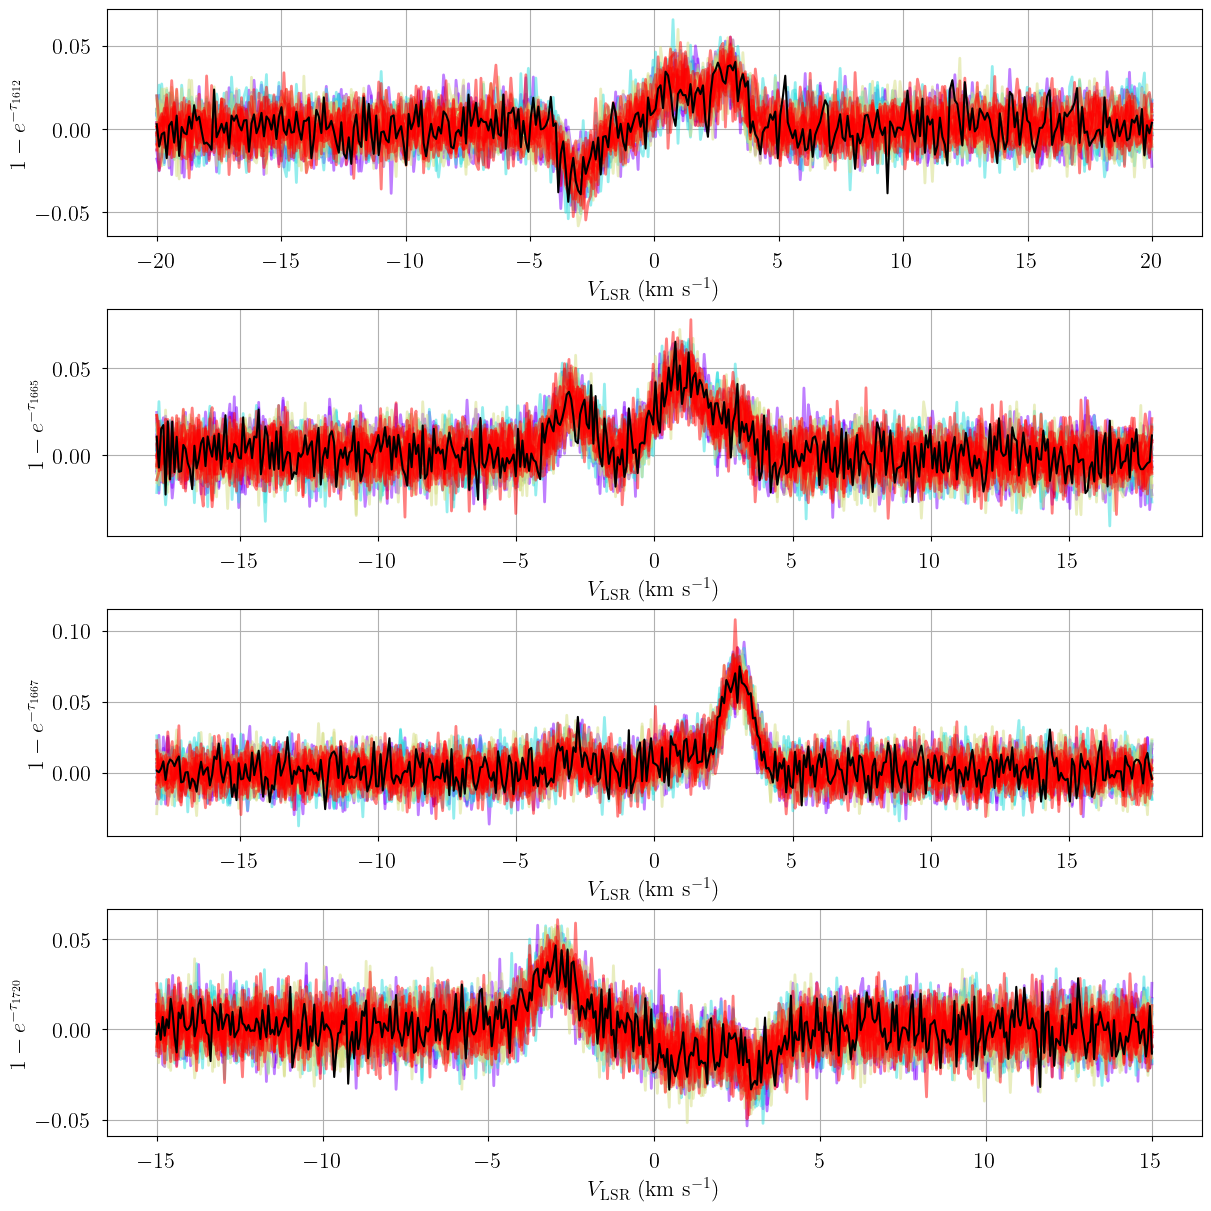

In [11]:
from bayes_spec.plots import plot_predictive

posterior = opt.best_model.sample_posterior_predictive(
    thin=100, # keep one in {thin} posterior samples
)
axes = plot_predictive(opt.best_model.data, posterior.posterior_predictive)
axes.ravel()[0].figure.set_size_inches(12, 12)